In [27]:
#This is a starting point
#uncomment below to install merlin library
#!pip install merlin, nvtabular, merlin.models
#I had to downgrade keras to 12.2.0 there maybe issues regarding tensorflow in the future
#run lines below if you have also have an error ab not finding a keras package

#!pip uninstall keras
#!pip install keras==2.12.0


#These are the same imports from
#https://github.com/NVIDIA-Merlin/models/blob/main/examples/02-Merlin-Models-and-NVTabular-integration.ipynb
import os
import pandas as pd
import numpy as np
import nvtabular as nvt
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import polars as pl

from sklearn.model_selection import train_test_split

from merlin.models.utils.example_utils import workflow_fit_transform
import merlin.io
import tensorflow as tf

import merlin.models.tf as mm
from merlin.io.dataset import Dataset
from nvtabular.ops import *
from merlin.core.utils import download_file
from merlin.schema.tags import Tags

### To-do

1. Clean data << Prices on user_interactions are not what they should be... probably is more
2. EDA
3. Transform timestamps
4. Find out why certain things are crashing the model
5. Learn about models and optimizers

# Load and split

In [28]:
df = pd.read_csv('/Users/andrew/Desktop/projects/recsys_data/2023-10-05 9_23pm (2).csv').dropna()
#  ^ This needs point to your local .csv too big for github

#accidentally added an extra CLICKSTREAM_EVENTS_TOTAL column
df['TARGET'] = 0

#Different values for different event_names

df.loc[df['EVENT_NAME'] == 'order', 'TARGET'] = 2
df.loc[df['EVENT_NAME'] == 'product_viewed', 'TARGET'] = 1

full_df = df

df = df.sample(40000)

In [29]:
df.columns

Index(['USER_ID', 'COUNTRY', 'DERIVED_GENDER_BY_NAME',
       'CLICKSTREAM_EVENTS_TOTAL', 'FIRST_PURCHASE_AT', 'FIRST_VISIT_AT',
       'LATEST_VISIT_AT', 'LATEST_PURCHASE_AT', 'DAYS_SINCE_FIRST_VISIT',
       'DAYS_SINCE_FIRST_PURCHASE', 'DAYS_SINCE_LAST_VISIT',
       'DAYS_SINCE_LAST_PURCHASE', 'RECENT_VISIT', 'UNIQUE_PURCHASE_COUNT',
       'MULTIPLE_BUYER', 'EVENT_NAME', 'EVENT_TIMESTAMP', 'ITEM_ID',
       'PRICE_INFORMATION', 'DAYS_SINCE_INTERACTION', 'AVG_REVIEW_SCORE',
       'STYLE', 'TAXONOMY_STYLE', 'COLOR_NAME', 'PRODUCT_CLASS',
       'PRODUCT_SUBCLASS', 'TEAM', 'FRANCHISE', 'PRODUCT_GROUP', 'TARGET'],
      dtype='object')

In [30]:
negative_sample = df[['USER_ID', 'ITEM_ID', 'TARGET']]

user_df = df[['USER_ID', 'ITEM_ID', 'COUNTRY', 'DERIVED_GENDER_BY_NAME', 'CLICKSTREAM_EVENTS_TOTAL', 'FIRST_PURCHASE_AT', 'FIRST_VISIT_AT',
              'LATEST_VISIT_AT', 'LATEST_PURCHASE_AT', 'DAYS_SINCE_FIRST_VISIT', 'DAYS_SINCE_FIRST_PURCHASE', 'DAYS_SINCE_LAST_VISIT',
              'DAYS_SINCE_LAST_PURCHASE', 'RECENT_VISIT']]
item_df = df[['ITEM_ID', 'USER_ID', 'PRICE_INFORMATION', 'AVG_REVIEW_SCORE',
              'STYLE', 'TAXONOMY_STYLE', 'COLOR_NAME', 'PRODUCT_CLASS',
              'PRODUCT_SUBCLASS', 'TEAM', 'FRANCHISE', 'PRODUCT_GROUP']] #Took away timestamps and days since interaction

In [31]:
sections = df.shape[0]//10000
negative_data = []
item_map = full_df['ITEM_ID'].unique()
rng = np.random.default_rng()
zero_multiplier = 1 #https://datascience.stackexchange.com/questions/6939/ratio-of-positive-to-negative-sample-in-data-set-for-best-classification
#The above datascience stackexchange says 1:1 is a good ratio, i didn't look into it that much tho

for chunk in np.array_split(df, sections):
    user_id_counts = pd.value_counts(chunk.USER_ID)
    item_ids = []
    for user_id, count in user_id_counts.items():
        item_ids.append(np.random.randint(low = 0, high = item_map.shape[0], size = count*zero_multiplier))
    item_ids = np.concatenate(item_ids)
    negative_data.append(pd.DataFrame({'USER_ID': np.repeat(user_id_counts.index, repeats = user_id_counts.values*zero_multiplier),
                                       'ITEM_ID': item_map[item_ids],
                                       'TARGET': 0}))
negative_data.append(negative_sample)
sample_data = pd.concat(negative_data)
sample_data = sample_data.reset_index(drop = True)

In [32]:
#it was a battle to merge user info and item info with negatively sampled df can't promise its 100% correct

In [33]:
df_subset = sample_data.merge(user_df, on = ['USER_ID', 'ITEM_ID'], how = 'outer').sort_values(['USER_ID', 'TARGET'], ascending=False).drop_duplicates(subset = ['USER_ID', 'ITEM_ID']).fillna(method='bfill')

In [34]:
df_subset = df_subset.merge(item_df, on = ['USER_ID', 'ITEM_ID'], how = 'outer').sort_values(['ITEM_ID', 'TARGET'], ascending=False).drop_duplicates(subset = ['USER_ID', 'ITEM_ID']).fillna(method='bfill')

In [35]:
df = df_subset

In [36]:
df.columns

Index(['USER_ID', 'ITEM_ID', 'TARGET', 'COUNTRY', 'DERIVED_GENDER_BY_NAME',
       'CLICKSTREAM_EVENTS_TOTAL', 'FIRST_PURCHASE_AT', 'FIRST_VISIT_AT',
       'LATEST_VISIT_AT', 'LATEST_PURCHASE_AT', 'DAYS_SINCE_FIRST_VISIT',
       'DAYS_SINCE_FIRST_PURCHASE', 'DAYS_SINCE_LAST_VISIT',
       'DAYS_SINCE_LAST_PURCHASE', 'RECENT_VISIT', 'PRICE_INFORMATION',
       'AVG_REVIEW_SCORE', 'STYLE', 'TAXONOMY_STYLE', 'COLOR_NAME',
       'PRODUCT_CLASS', 'PRODUCT_SUBCLASS', 'TEAM', 'FRANCHISE',
       'PRODUCT_GROUP'],
      dtype='object')

In [37]:
#num rows
data_size = df.shape[0]

train_split_ratio = int(.33 * data_size)

train = df[:-train_split_ratio].to_parquet("train.parquet")
valid = df[-train_split_ratio:].to_parquet("valid.parquet")

In [38]:
len(sample_data[sample_data['TARGET'] > 0])/len(sample_data)

0.4213125

# EDA

# NVTabular

In [39]:
#This is how to iniate a dataset using NVtabular an NVIDIA 
#optimized ETL/feature engineering(i think?) library
#data = nvt.io.dataset.Dataset('data/reviews.csv')

In [40]:
categorical_user_features = ['COUNTRY']
categorical_item_features = ['STYLE', 'TAXONOMY_STYLE', 'COLOR_NAME', 'PRODUCT_CLASS', 'PRODUCT_SUBCLASS', 'TEAM', 'FRANCHISE', 'PRODUCT_GROUP']

In [41]:
#Features needed to Transform still: FIRST_PURCHASE_AT, FIRST_VISIT_AT, LATEST_VISIT_AT
# LATEST_PURCHASE_AT, EVENT_TIMESTAMP

In [42]:
#DON'T FORGET TARGET ENCODING CATEGORICAL VALUES

In [43]:
user_id = ["USER_ID"] >> Categorify(dtype = "int32", out_path='categories') >> TagAsUserID()
item_id = ["ITEM_ID"] >> Categorify(dtype = "int32", out_path='categories') >> TagAsItemID()

target = (
    #Turn categorical into continuous
    nvt.ColumnSelector(["TARGET"])
    #>> LambdaOp(lambda col: (col > 0).astype("int32")) CHANGES ALL WEIGHTS TO 1 
    >> AddTags(["binary_classification", "target"])
    >> Rename(name="INTERACTION_BINARY")
)

item_features = categorical_item_features >> Categorify(dtype = "int32") >> TagAsItemFeatures()
user_features = categorical_user_features >> Categorify(dtype = "int32") >> TagAsUserFeatures()

In [44]:
#Make this more succinct
CLICKSTREAM_EVENTS_TOTAL = (
    nvt.ColumnSelector(['CLICKSTREAM_EVENTS_TOTAL'])
    >>FillMissing(1)
    >>LogOp()
    >>Normalize()
    >>LambdaOp(lambda col: col.astype("float32"))
    >>TagAsUserFeatures()
)

#has the price changed over time?
PRICE_INFORMATION = (
    ['PRICE_INFORMATION']
    >>FillMissing(1)
    >>LogOp()
    >>Normalize()
    >>LambdaOp(lambda col: col.astype("float32"))
    >>TagAsItemFeatures()
)

AVG_REVIEW_SCORE = (
    ['AVG_REVIEW_SCORE']
    >>Normalize()
    >>LambdaOp(lambda col: col**2)
    >>TagAsItemFeatures()
)

INTERACTION_TIMESTAMP = (
    nvt.ColumnSelector(['DAYS_SINCE_INTERACTION'])
    #>>Normalize()
    >>TagAsUserFeatures()
)

DAYS_SINCE_LAST_VISIT = (
    nvt.ColumnSelector(['DAYS_SINCE_LAST_VISIT'])
    >>TagAsUserFeatures()
)


In [45]:
categorical_features = (categorical_item_features) #Just a place holder... redo with better categories
user_cat_features = (user_features)
label = nvt.ColumnSelector(['TARGET'])
te_features = categorical_features >> TargetEncoding(label)
user_feats = user_cat_features >> TargetEncoding(label)
te_features_norm = te_features >> Normalize() >> LambdaOp(lambda col: col.astype('float32')) >> TagAsItemFeatures()
user_cat_features_norm = user_feats >> Normalize() >> LambdaOp(lambda col: col.astype('float32')) >> TagAsItemFeatures()

In [46]:
output = (
    user_id + 
    item_id +
    target +
    CLICKSTREAM_EVENTS_TOTAL + 
    te_features +
    user_feats +
    # INTERACTION_TIMESTAMP +
    DAYS_SINCE_LAST_VISIT + 
    #PRICE_INFORMATION + #<< THIS CAUSES MODEL TO CRASH AND BURN
    AVG_REVIEW_SCORE
)

workflow_fit_transform(output, 'train.parquet', 'valid.parquet', 'integration') #< What is integration

/Users/andrew/anaconda3/lib/python3.11/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/Users/andrew/anaconda3/lib/python3.11/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/Users/andrew/anaconda3/lib/python3.11/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/Users/andrew/anaconda3/lib/python3.11/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/Users/andrew/anaconda3/lib/python3.11/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Datase

In [47]:
train = merlin.io.Dataset(
    os.path.join("integration", "train"), engine="parquet"
)
valid = merlin.io.Dataset(
    os.path.join("integration", "valid"), engine="parquet"
)

/Users/andrew/anaconda3/lib/python3.11/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/Users/andrew/anaconda3/lib/python3.11/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


<Axes: >

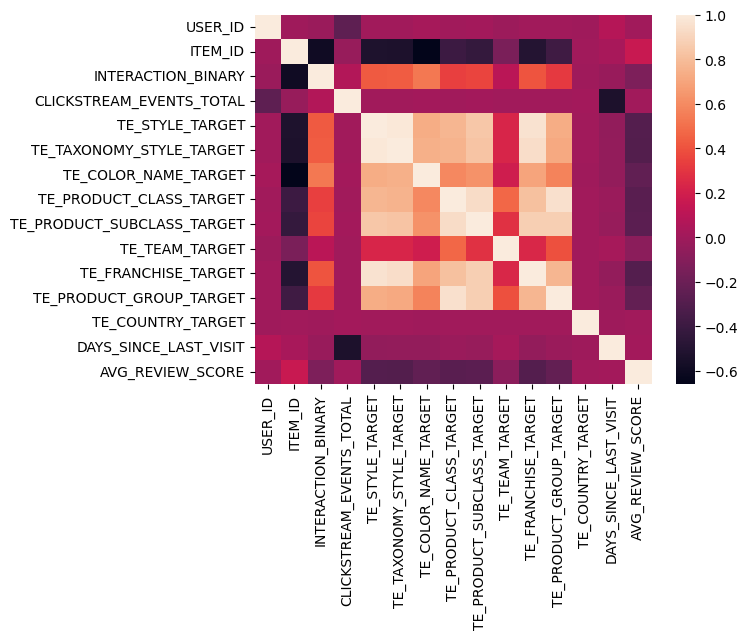

In [48]:
data = pl.read_parquet('integration/train/part_0.parquet').to_pandas().corr()
sns.heatmap(data)

In [49]:
data

,USER_ID,ITEM_ID,INTERACTION_BINARY,CLICKSTREAM_EVENTS_TOTAL,TE_STYLE_TARGET,TE_TAXONOMY_STYLE_TARGET,TE_COLOR_NAME_TARGET,TE_PRODUCT_CLASS_TARGET,TE_PRODUCT_SUBCLASS_TARGET,TE_TEAM_TARGET,TE_FRANCHISE_TARGET,TE_PRODUCT_GROUP_TARGET,TE_COUNTRY_TARGET,DAYS_SINCE_LAST_VISIT,AVG_REVIEW_SCORE
USER_ID,1.000000,-0.004699,-0.023486,-0.254999,0.007154,0.006060,0.023341,0.007735,0.011771,-0.011301,0.005411,0.006529,-0.003903,0.081640,0.002299
ITEM_ID,-0.004699,1.000000,-0.591005,-0.035011,-0.526568,-0.534457,-0.659411,-0.394458,-0.430147,-0.142497,-0.501010,-0.382479,0.007176,0.033976,0.161952
INTERACTION_BINARY,-0.023486,-0.591005,1.000000,0.070995,0.426234,0.433228,0.529067,0.333303,0.357276,0.099687,0.407574,0.315087,-0.001810,-0.030590,-0.129347
CLICKSTREAM_EVENTS_TOTAL,-0.254999,-0.035011,0.070995,1.000000,0.008031,0.006972,0.010884,0.005390,0.010684,0.005222,0.004393,0.007882,0.009039,-0.530154,0.005247
TE_STYLE_TARGET,0.007154,-0.526568,0.426234,0.008031,1.000000,0.984777,0.731308,0.770429,0.843067,0.231902,0.956132,0.730708,0.005300,-0.050626,-0.294731
TE_TAXONOMY_STYLE_TARGET,0.006060,-0.534457,0.433228,0.006972,0.984777,1.000000,0.745529,0.758860,0.830138,0.234264,0.941290,0.719707,0.004698,-0.048247,-0.296715
TE_COLOR_NAME_TARGET,0.023341,-0.659411,0.529067,0.010884,0.731308,0.745529,1.000000,0.588008,0.629878,0.188213,0.697429,0.566957,-0.000165,-0.047686,-0.243708
TE_PRODUCT_CLASS_TARGET,0.007735,-0.394458,0.333303,0.005390,0.770429,0.758860,0.588008,1.000000,0.931428,0.474557,0.815113,0.951763,0.002820,-0.017700,-0.272868
TE_PRODUCT_SUBCLASS_TARGET,0.011771,-0.430147,0.357276,0.010684,0.843067,0.830138,0.629878,0.931428,1.000000,0.282311,0.876104,0.876542,0.003712,-0.036097,-0.267927
TE_TEAM_TARGET,-0.011301,-0.142497,0.099687,0.005222,0.231902,0.234264,0.188213,0.474557,0.282311,1.000000,0.239770,0.390854,0.003393,0.021327,-0.077839


## Model

In [134]:
import tensorflow as tf

recall = []
precision = []
rang = np.arange(1, 10)

for i in rang:
    model = mm.benchmark.NCFModel(
        train.schema,
        embedding_dim=64,
        mlp_block=mm.MLPBlock([128, 64]),
        prediction_tasks=mm.BinaryOutput(train.schema.select_by_tag(Tags.TARGET).column_names[0]),
    )

    loss=tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate = .0175), loss = loss, run_eagerly=False, metrics=[tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name='precision')]);
    model.fit(train, validation_data=valid, batch_size=8000, epochs = 1); #Less epochs, more accurate valid... less accurate train
    x = model.evaluate(valid, batch_size = 1024, return_dict = True)
    recall.append(x['recall'])
    precision.append(x['precision'])

25/25 [==============================] - 0s 1ms/step - loss: 0.6774 - recall: 0.7516 - precision: 0.4658 - regularization_loss: 0.0000e+00 - loss_batch: 0.6778


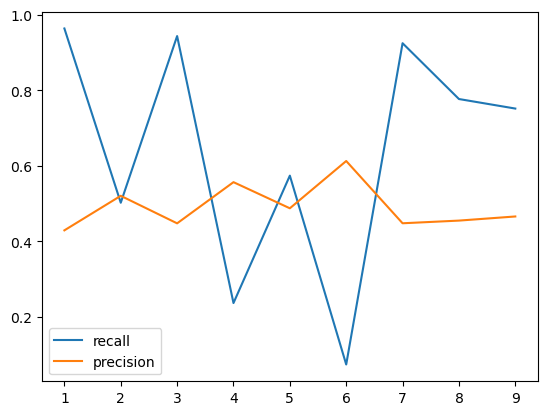

In [135]:
plt.plot(rang, recall, label = 'recall')
plt.plot(rang, precision, label = 'precision')
plt.legend()
plt.show()

In [125]:
preds = model.predict(train, batch_size = 1024)

(array([14532.,  2575.,  2016.,  1922.,  2651.,  6015.,  8741.,  8022.,
         3961.,   321.]),
 array([3.78837954e-04, 8.54430497e-02, 1.70507267e-01, 2.55571485e-01,
        3.40635687e-01, 4.25699919e-01, 5.10764122e-01, 5.95828354e-01,
        6.80892587e-01, 7.65956759e-01, 8.51020992e-01]),
 <BarContainer object of 10 artists>)

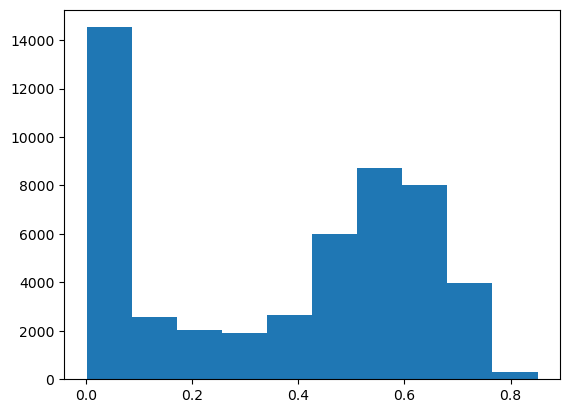

In [126]:
plt.hist(preds)

In [55]:
model.evaluate(valid, batch_size = 1024, return_dict = True)

25/25 [==============================] - 0s 1ms/step - loss: 0.6838 - recall: 0.0000e+00 - precision: 0.0000e+00 - regularization_loss: 0.0000e+00 - loss_batch: 0.6858


{'loss': 0.6838032007217407,
 'recall': 0.0,
 'precision': 0.0,
 'regularization_loss': 0.0,
 'loss_batch': 0.7165533900260925}

In [56]:
model.evaluate(valid, batch_size = 1024, return_dict = True)

25/25 [==============================] - 0s 1ms/step - loss: 0.6838 - recall: 0.0000e+00 - precision: 0.0000e+00 - regularization_loss: 0.0000e+00 - loss_batch: 0.6858


{'loss': 0.6838032007217407,
 'recall': 0.0,
 'precision': 0.0,
 'regularization_loss': 0.0,
 'loss_batch': 0.7165533900260925}

# Model

In [110]:
recall = []
precision = []

arr = [
    tf.keras.losses.BinaryCrossentropy(),
    tf.keras.losses.BinaryFocalCrossentropy(),
    tf.keras.losses.Hinge(),
    tf.keras.losses.SquaredHinge()
    
]

model_fb = mm.DLRMModel(
    train.schema,
    embedding_dim = 64,
    top_block = mm.MLPBlock([128, 64, 32]),
    bottom_block = mm.MLPBlock([128, 64]),
)

loss = arr[0]
model_fb.compile(optimizer = keras.optimizers.Adam(learning_rate = .0175), loss = loss)
model_fb.fit(train, batch_size = 1024, epochs = 1)
x = model_fb.evaluate(valid, batch_size = 1024, return_dict = True)
recall.append(x['auc'])

preds_2 = model_fb.predict(valid, batch_size = 1024)

25/25 [==============================] - 0s 2ms/step - loss: 0.6341 - precision: 0.5502 - recall: 0.7445 - binary_accuracy: 0.6370 - auc: 0.7174 - regularization_loss: 0.0000e+00 - loss_batch: 0.6428


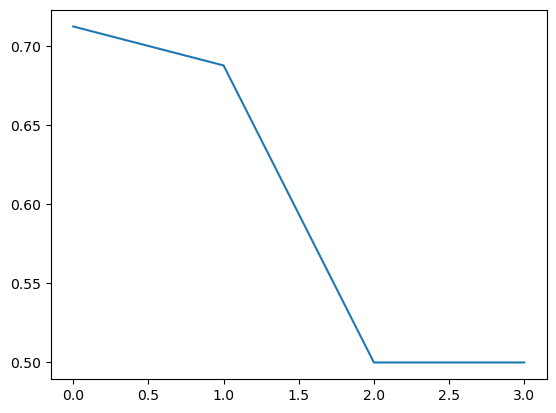

In [106]:
plt.plot(recall)

(array([  91.,    9.,  112., 1193., 3476., 4367., 1284., 2013., 6658.,
        5795.]),
 array([0.04181208, 0.10306066, 0.16430922, 0.22555779, 0.28680634,
        0.34805492, 0.40930349, 0.47055206, 0.53180063, 0.59304923,
        0.65429777]),
 <BarContainer object of 10 artists>)

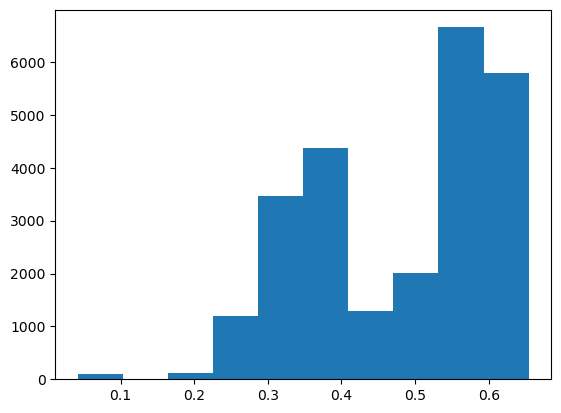

In [111]:
plt.hist(preds_2)

In [243]:
model_fb.evaluate(valid, batch_size = 1024, return_dict = True)

138/138 [==============================] - 0s 1ms/step - loss: nan - precision: 0.0000e+00 - recall: 0.0000e+00 - binary_accuracy: 0.9254 - auc: 0.7170 - regularization_loss: 0.0000e+00 - loss_batch: nan   


{'loss': nan,
 'precision': 0.0,
 'recall': 0.0,
 'binary_accuracy': 0.9254040718078613,
 'auc': 0.7170469760894775,
 'regularization_loss': 0.0,
 'loss_batch': nan}